<a href="https://colab.research.google.com/github/dsliwka/EEMP2024/blob/main/Notebooks/EngagementPredSampleSolutions_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Job Engagement**
----

- We work with the LPP data to train algorithms to predict job engagement
- The first cell is given code that cleans the data and generates a DataFrame dfp that we use for the prediction
- It already standardizes the survey scales (here engagement and the Big5)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats


## Read LPP Data
path_to_data = "https://raw.githubusercontent.com/dsliwka/EEMP2024/main/Data/LPP-CF_1215_v1.csv"
df = pd.read_csv(path_to_data)


## Keep only wave 2 (as here the LPP campus file has more information)
dfp=df[df.welle==2]

## Generate Engagement Scale
dfp=dfp.assign(enga=6-df.filter(regex="menga*").mean(axis=1))

## reverse health scale (as lower numbers represent better health in the survey)
dfp["mgesund_allg"]=6-dfp.mgesund_allg

## keep only rows where we have non-missing data on income, industry & engagement
dfp=dfp[dfp.meink_kateg.isnull()==False]
dfp=dfp[dfp.branche.isnull()==False]
dfp=dfp[dfp.enga.isnull()==False]

## Generate Big5 traits from items
dfp['conscientiousness']= (6-dfp.mbig_gruend +dfp.mbig_faul     + 6-dfp.mbig_effi)/3
dfp['extraversion']=      (6-dfp.mbig_komm   +dfp.mbig_zur      + 6-dfp.mbig_gesell)/3
dfp['neuroticism']=       (6-dfp.mbig_sorgen +dfp.mbig_entsp    + 6-dfp.mbig_nervoes)/3
dfp['openness']=          (6-dfp.mbig_origi	+6-dfp.mbig_kunst  + 6-dfp.mbig_phant  + 6-dfp.mbig_wissb)/4
dfp['agreeableness']=     (dfp.mbig_grob	    +6-dfp.mbig_verzeih+ 6-dfp.mbig_freundl)/3

## drop all rows in which either of the big5 traits are missing
dfp=dfp.dropna(subset=['conscientiousness', 'extraversion', 'neuroticism', 'openness', 'agreeableness'])

## Standardize all personality traits & engagement (i.e. substract the mean and divide by SD)
## Note: for simplicity we here use a function from package sciepy
dfp['conscientiousness'] = stats.zscore(dfp.conscientiousness)
dfp['extraversion'] = stats.zscore(dfp.extraversion)
dfp['neuroticism'] = stats.zscore(dfp.neuroticism)
dfp['openness'] = stats.zscore(dfp.openness)
dfp['agreeableness'] = stats.zscore(dfp.agreeableness)
dfp['enga'] = stats.zscore(dfp.enga)

## drop all columns with missing data:
dfp = dfp.dropna(axis=1)

## keep only subset of the variables
dfp=dfp[['enga','branche', 'ost', 'size',
       'bauswahl_interview', 'bauswahl_ac', 'bauswahl_kognit', 'bauswahl_pers',
       'bauswahl_arbeitsprobe', 'bauswahl_andere', 'bmagespr', 'bzv',
       'bentwplan', 'bbeurt', 'bvargehalt', 'bsonderz_nv', 'bmabefr',
       'bmabind_flexaz', 'bmabind_verg', 'bhomeoff', 'babsent_anz', 'msex',
       'alter', 'mstib', 'mleitung', 'maz_voll_teil', 'mheim', 'maz_freizeit',
       'mwb', 'mmagespr', 'mikt_nutz', 'mgesund_allg', 'mkind_anz_gr',
       'mkindu3','meink_kateg', 'conscientiousness','extraversion','neuroticism','openness','agreeableness']]

## As variable "brache" which contains the industry in which a person is working
## is categorial generate dummy variables for each industry
dfp =pd.get_dummies(dfp, columns=['branche'])

## inspect how many observations are remaining:
print("We have", dfp.shape[0], "observations and", dfp.shape[1], "variables.")


We have 886 observations and 44 variables.


Before we can train the different algorithms we have to specify the variable we want to predict (typically named y; here a Pandas series) and the feature matrix X (here we can just use a DataFrame that includes all variables except the variable we want to predict.


In [ ]:
## Assign the variable to be predicted
y = dfp.enga

## Assign the feature matrix (the predictors):
X=dfp.drop(columns='enga')



# **Decision Trees**
----

- We have to import the relevant packages
- We also here import pyplot to choose the size of the plotted tree


In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

dtree= DecisionTreeRegressor(max_depth=3).fit(X,y)
print("R²:", round(r2_score(y, dtree.predict(X)),3))

R²: 0.11


We can plot the tree to understand the prediction.

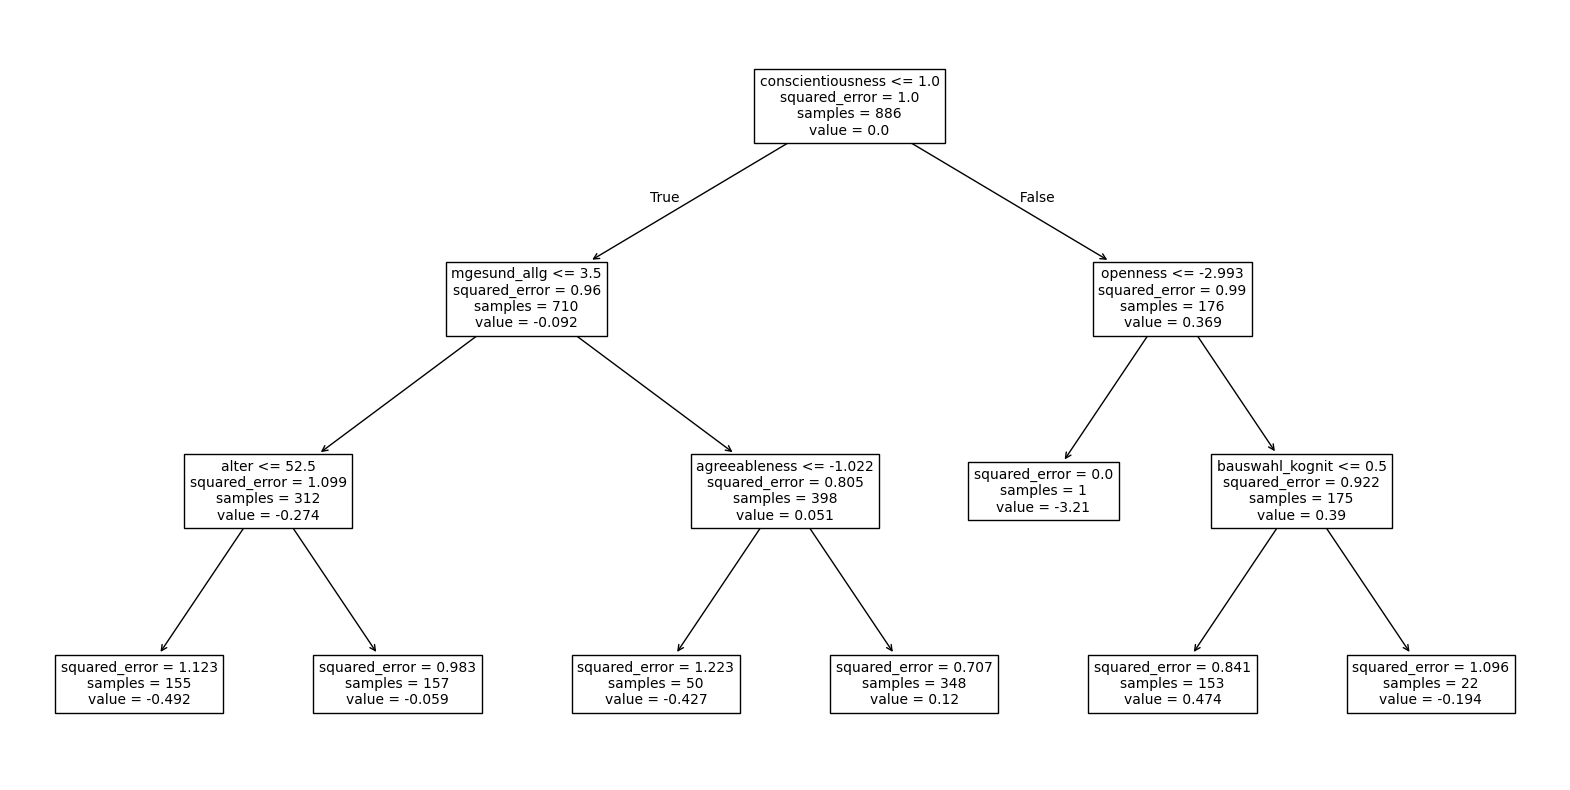

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=X.columns, fontsize=10)
plt.show()

**Interpretation**
- The tree gives us a visual representation of the data

- Here we allowed a depth of 3 such that we have up to 2³=8 leaves in the tree

- The plot of the tree here also shows the mean value of enga in each leaf. This gives the predicted value of enga for feature vectors that satisfy the path of yes/no conditions at each node up to that leaf.

- The "samples" stated in the leaf of the tree shows the number of observations in the leaf.

# **Train and Test R²**
----

- To avoid that our R² estimate is driven by overfitting we only use part of the sample to train the algorithm and check the MSE/R² on the remaining test sample.

- We use the train_test_split function from sklearn to make the split.

- Here we use 70% of the data for training and 30% for the test sample

- The function randomly determines which observation goes into the training and which goes into the test sample

- When we set a specific random state we can assure that the random numbers are the same when you run the code again


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=156)

dtree= DecisionTreeRegressor(max_depth=3).fit(X_train,y_train)

print("R²_train=", round(r2_score(y_train, dtree.predict(X_train)),2))
print("R²_test=",  round(r2_score(y_test, dtree.predict(X_test)),2))

R²_train= 0.15
R²_test= 0.04


**Interpretation**

- While the training R² is similar to the R² in the whole sample (here actually by chance a bit larger), the test R² is much smaller

- Hence, the prediction accuracy is much smaller than a simple in-sample estimate would show.

In [ ]:
for d in range(1,6):
  dtree= DecisionTreeRegressor(max_depth=d).fit(X_train,y_train)
  print("Depth ", d)
  print("Train R²:", round(r2_score(y_train, dtree.predict(X_train)),3))
  print("Test R²:", round(r2_score(y_test, dtree.predict(X_test)),3))
  print("")

Depth  1
Train R²: 0.04
Test R²: 0.019

Depth  2
Train R²: 0.083
Test R²: 0.036

Depth  3
Train R²: 0.148
Test R²: 0.037

Depth  4
Train R²: 0.225
Test R²: 0.01

Depth  5
Train R²: 0.304
Test R²: -0.029



**Interpretation**

- Here we compare the test R² between trees of different depths (I here do in a loop, but you can of course just copy the code and vary max_depth).

- We see that the test R² first increases but already for a depth of 4 falls and even becomes negative for a depth of 5.

- This is due to overfitting: the deeper tree picked up patterns which are just due to the sampling.

- A more shallow tree exhibits thus a lower variance (even though it comes with more bias)

# **Random Forests**
----

We here train a random forest, an ensemble of many trees (here 500)
- The RandomForestRegressor class performs all the heavy lifting (using bootsrap aggregation - i.e. drawing different bootstrap samples for each tree - and randomly choosing the subset of features that each tree can choose from at each node for splitting the data)

- Here we use the square root of the number of all features


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=156).fit(X_train, y_train)

print("Test R²:", round(r2_score(y_test, forest.predict(X_test)),3))


Test R²: 0.091


A Random Forest gives us a substantially better prediction that a single tree. The low prediction quality of a single tree is due to the problem that a shallow tree exhibits a large bias (it cannot account for complex patterns in the data) and a deep tree leads to overfitting.
Moreover, splits made in the lower part of a tree can use less and less data and, in turn, learning about the role of feautures that do not show up at the top of the tree is more difficult and overfitting more likely (note that for instance a further split on the fourth level of a tree can only use 1/8 of the data).  
The random forest reduces these problems. The randomness introduced through bagging and by restricting splits to randomly chosen subset of the features allows the forest to learn also where it is more difficult to learn. Each single tree has a lot of variance but the aggregation (computing the average prediction across the trees) reduces this variance.   

# **Permutation Feature Importance**
----

- If we want to find out how important a feature is for our prediction, we can compute the permutation feature importance

- There are several alternative methods, but this one works for all algorithms.

- The idea is simple: To estimate the importance of a feature we just shuffle the values of this feature in our test data (so that it becomes uninformative) and compare the increase in the test MSE when we do that.

- We repeat this several times (below n_repeats = 30 times) for each feature and average the increase in the test MSE from each repeat

- This gives us an idea of the feature importance --> how much worse does our prediction get, when we make a feature uninformative
   


In [49]:
from sklearn.inspection import permutation_importance

pi=permutation_importance(forest, X_test, y_test, n_repeats=30, random_state=156)

pi.importances_mean

array([ 0.0023372 ,  0.00737624,  0.00252929,  0.00010356, -0.00039614,
       -0.00159072, -0.00416823, -0.00307159,  0.00110163,  0.00049728,
       -0.00155797,  0.0013127 , -0.00282428,  0.0009963 ,  0.00177291,
       -0.00288599, -0.00466582,  0.00065549, -0.00283164, -0.00104515,
        0.02273127,  0.00204804,  0.00248711,  0.00171206, -0.00012709,
        0.00075007,  0.00055084,  0.00297235, -0.003308  ,  0.0201993 ,
        0.00388915,  0.00483917,  0.00191018,  0.02063255,  0.00236164,
        0.00949036,  0.01939817,  0.01783527,  0.00129572,  0.00013161,
        0.00274952,  0.00308164,  0.0013509 ])

Resuts become more accessible when we sort the features by their importance and plot them.

<Axes: >

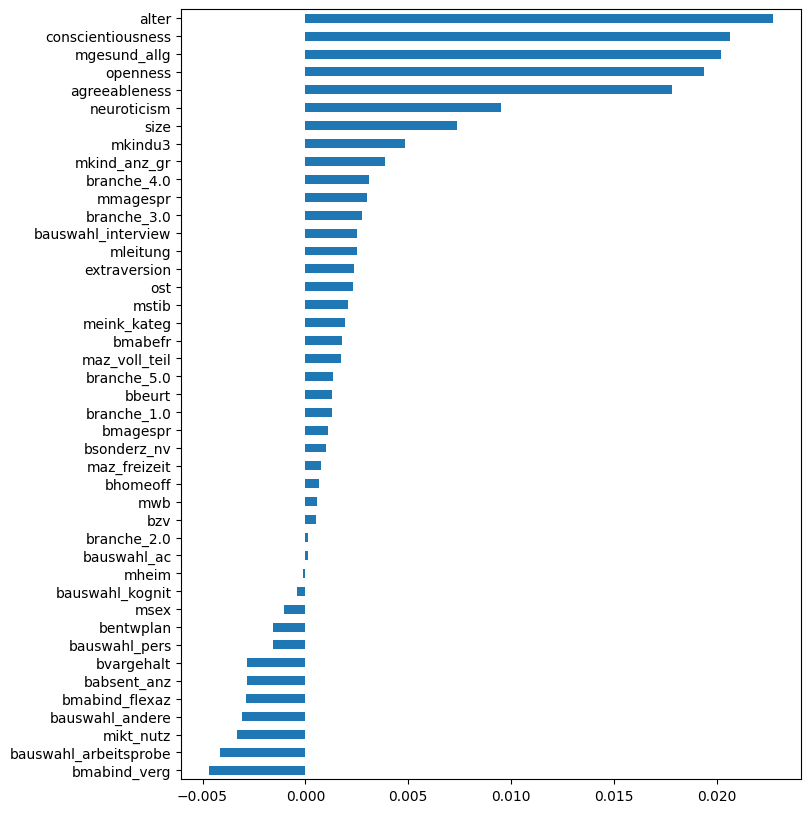

In [50]:
plt.figure(figsize=(8,10))
pd.Series(pi.importances_mean, index=X.columns).sort_values().plot(kind='barh')

**Interpretation**
- Here for instance age ("alter"), conscientiousness, mgesund_allg (i.e. health status) and openness turn out to be important for the prediction.

- The Big5 Personality traits are very predictive. As a side note: These are evaluated subjectively in the same survey as engagement - hence, there are likely be affected by common shocks (such as mood at the day of the survey). Recall that this phenomenon is called *common method bias*. Hence, the association tends to be high and we should be more careful in interpreting these patterns. One way how to deal with that would be to use for instance personality trait scores for the same people from an earlier survey wave.

- Of the objectively measurable variables age (variable alter) is the most predictive one.

- The variables starting with a "b" come from a survey filled out by the employer. They are mostly binary variables assessing whethe a firm uses a certain practice or not. Check the LPP campus file documentation if you are interested.


\

Note:
- The feature importance tells us only whether a feature is important, but it does not tell us the direction of the association

- There are also some negative values down in the list. This here only tells us that the random perturbations of these variables actually (by chance) improved the prediction quality. Hence, you can conclude that these features are not very predictive



# **Partial Dependence Plots**
----

- The permutation feature importance above only told us whether a feature is important for the prediction, but not the direction of the association, or whether the association is monotonic or not

- To see the direction of the association we can simply plot the prediction

- We do this in partial dependence plots

- Below we plot  this for two variables mgesund_allg (health status) and alter (age)

\

Note:
- Importantly, the preditions are plotted holding all other variables constant at their mean (therefore "partial" dependence).

- Be careful when features are highly correlated.

- Moreover, when not exogenously varied the connections cannot be interpreted in a causal manner.

- But these plots are very useful to understand how the prediction works

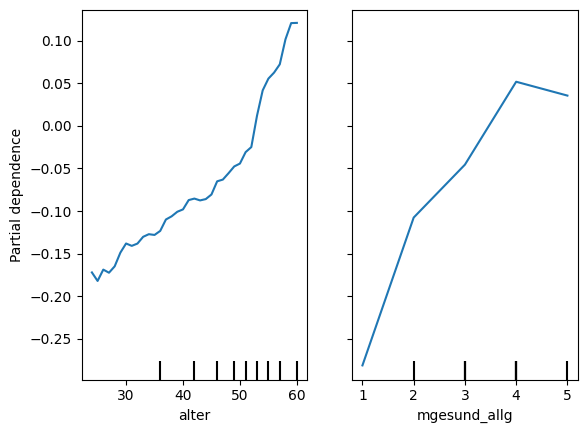

In [51]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(forest,X,["alter","mgesund_allg"])

- You can also plot a two-dimensional depencence plot.
- This is particularly useful when expecting interaction effects.
- The following graph shows you the predicted engagement for combinations of age and health status: the old and healthy are the most engaged

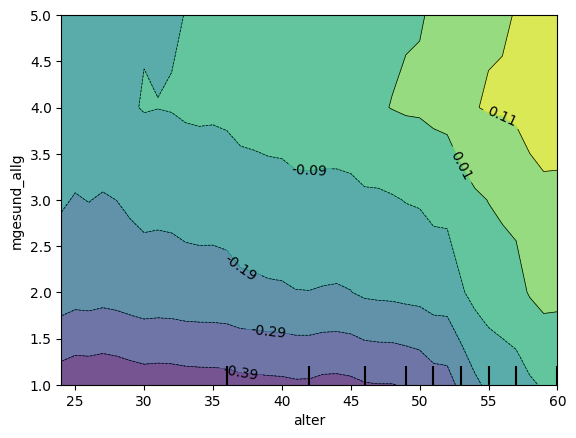

In [52]:
PartialDependenceDisplay.from_estimator(forest,X,[("alter","mgesund_allg")])

# **Lasso Regression & Cross Validation**
----
- Lasso regression is useful to pick the set of independent variables in a regression when you want to make predictions but have a large number of potential explanatory variables

- It penalizes regression coefficients when deviating from zero (a process also called regularization) & thus leads to a simpler model with fewer coefficients

- This of course will introduce bias but will reduce variance

- The hyperparameter $\alpha$ sets the penalty - the higher $\alpha$, the higher the bias/the "simpler" the model, but the lower the variance

- We can find out the "optimal" value of $\alpha$ through hyperparameter-tuning using cross-validation

- Conveniently, for Lasso there is a class LassoCV that does this automatically  

In [54]:
from sklearn.linear_model import LassoCV

lasso =LassoCV(cv=5, random_state=156).fit(X_train,y_train)

print("Alpha: ", round(lasso.alpha_,3))
print("Test R²: ", round(r2_score(y_test, lasso.predict(X_test)),3))


Alpha:  0.032
Test R²:  0.149


**Interpretation:**
- The "optimal" value of $\alpha$ is about 0.032; this value balances bias and variance for our data set
- It is of course interesting to see how the model was simplified. To see this we can print the coefficient estimates:

In [55]:
c=pd.Series(lasso.coef_, index=X.columns)
print(c)

ost                      0.000000
size                    -0.021321
bauswahl_interview      -0.000000
bauswahl_ac              0.000000
bauswahl_kognit         -0.000000
bauswahl_pers            0.000000
bauswahl_arbeitsprobe    0.000000
bauswahl_andere         -0.000000
bmagespr                -0.000000
bzv                     -0.000000
bentwplan               -0.000000
bbeurt                  -0.000000
bvargehalt              -0.000000
bsonderz_nv              0.000000
bmabefr                  0.000000
bmabind_flexaz          -0.000000
bmabind_verg            -0.000000
bhomeoff                -0.000000
babsent_anz              0.007772
msex                     0.000000
alter                    0.016426
mstib                    0.000000
mleitung                 0.000000
maz_voll_teil           -0.000000
mheim                   -0.000000
maz_freizeit            -0.000357
mwb                      0.118807
mmagespr                 0.000000
mikt_nutz                0.000000
mgesund_allg  

Actually, it is often more convenient to print only the non-zero coefficients:

In [56]:
print(c[c!=0])

size                -0.021321
babsent_anz          0.007772
alter                0.016426
maz_freizeit        -0.000357
mwb                  0.118807
mgesund_allg         0.123235
conscientiousness    0.109260
extraversion         0.096625
neuroticism         -0.046072
openness             0.063351
agreeableness        0.054882
dtype: float64


Or count the number of non-zero coefficients:

In [58]:
print("Lasso picked " + str(sum(c != 0)) + " variables and eliminated the other " +  str(sum(c == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 32 variables


If we want to have a regression table, we can go back to pyfixest to run a regression that only includes these variables as explanatory variables. We can do it mannualy. But the following code creates a regression formula for it automatically.

In [59]:
!pip install pyfixest -q
import pyfixest as pf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.7 MB/s eta 0:00:00


In [67]:
import pyfixest as pf

reg_formula = 'enga ~ ' + ' + '.join(c[c!= 0].index)
print("We run the following regression:")
print(reg_formula)
print()
reg=pf.feols(reg_formula, data=dfp)
pf.etable(reg)

We run the following regression:
enga ~ size + babsent_anz + alter + maz_freizeit + mwb + mgesund_allg + conscientiousness + extraversion + neuroticism + openness + agreeableness



GT(_tbl_data=   level_0            level_1                       0
0     coef               size     -0.055 <br> (0.031)
1     coef        babsent_anz      0.010 <br> (0.007)
2     coef              alter   0.019*** <br> (0.004)
3     coef       maz_freizeit     -0.022 <br> (0.030)
4     coef                mwb    0.171** <br> (0.065)
5     coef       mgesund_allg   0.187*** <br> (0.033)
6     coef  conscientiousness    0.109** <br> (0.035)
7     coef       extraversion      0.064 <br> (0.034)
8     coef        neuroticism    -0.074* <br> (0.033)
9     coef           openness   0.125*** <br> (0.033)
10    coef      agreeableness   0.112*** <br> (0.033)
11    coef          Intercept  -1.539*** <br> (0.296)
12   stats       Observations                     886
13   stats          S.E. type                     iid
14   stats      R<sup>2</sup>                   0.159, _body=<great_tables._gt_data.Body object at 0x7ce7fb4ce6b0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7ce7fa76c5e0>, _spanners=Spanners([SpannerInfo(spanner_id='enga', spanner_level=1, spanner_label='enga', spanner_units=None, spanner_pattern=None, vars=['0'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7ce7fa76de70>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', 